In [1]:
%matplotlib inline
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
pd.set_option('display.max_colwidth', None)


## Carga de Datos

In [2]:
main_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
main_dir

'/home/diego/got-rag-chatbot'

In [3]:
# Ruta al archivo de resultados generado por el Juez

RESULTS_PATH = os.path.join(main_dir, 'data', 'eval', 'evaluation_results_4.jsonl')

def load_results(path):
    if not os.path.exists(path):
        print(f"❌ No se encontró el archivo: {path}")
        return pd.DataFrame()
    
    # Leemos línea por línea para evitar errores de parseo masivo
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError:
                continue
    return pd.DataFrame(data)

df = load_results(RESULTS_PATH)

print(f"✅ Datos cargados: {len(df)} evaluaciones.")
df.head(2)

✅ Datos cargados: 118 evaluaciones.


,id,question,prediction,ground_truth,score,reason,type,evidence_source
0,gen_0,Who played the character Mirri Maz Duur?,"The Maester's records confirm that the character Mirri Maz Duur was portrayed by the actress and musician **Mia Soteriou**.\n\nShe was confirmed in the role on 29 September 2010. Mia Soteriou is also known for her work as an actor and vocal coach in the film *Mamma Mia!*, and for appearances in British television series such as *Holby City*, *The Bill*, and *Absolutely Fabulous*.",Mia Soteriou,1,"The prediction correctly identifies Mia Soteriou as the actress, which matches the ground truth. The additional information provided is also correct and relevant.",Unknown,Graph
1,gen_1,What religion did Mirri Maz Duur follow?,"Mirri Maz Duur followed the religion that worships the **Great Shepherd**.\n\nShe was known among the Lhazareen as a godswife (or priestess) of the Great Shepherd, a position that involved healing and acting as a wise woman. Though she also practiced blood magic, which caused Khal Drogo's bloodrider Qotho to call her a maegi (witch), the archives confirm her primary religious affiliation was with the Lhazareen god.",Great Shepherd,1,"The prediction correctly identifies the religion as the Great Shepherd, matching the ground truth. The additional information provided is accurate context and does not contradict or add incorrect facts.",Unknown,Graph


## Métricas Globales (KPIs)

In [4]:
if not df.empty:
    accuracy = df['score'].mean() * 100
    total = len(df)
    correct = df['score'].sum()
    failed = total - correct

    print("="*40)
    print(f"📊 REPORTE DE DESEMPEÑO GENERAL")
    print("="*40)
    print(f"🎯 Precisión Global (Accuracy):  {accuracy:.2f}%")
    print(f"✅ Respuestas Correctas:        {correct}")
    print(f"❌ Fallos (Score 0):            {failed}")
    print("="*40)
else:
    print("⚠️ El dataframe está vacío.")

📊 REPORTE DE DESEMPEÑO GENERAL
🎯 Precisión Global (Accuracy):  80.51%
✅ Respuestas Correctas:        95
❌ Fallos (Score 0):            23


## Análisis por Fuente de Evidencia (Grafo vs Texto)

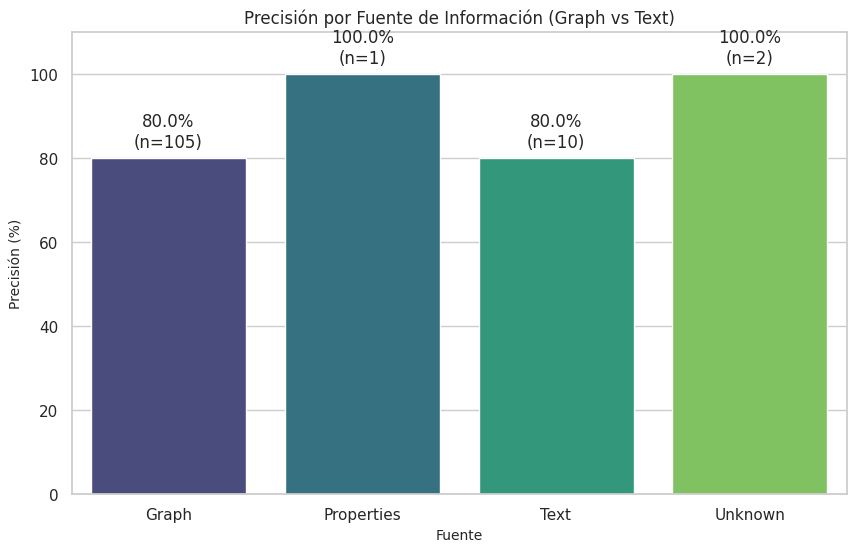

In [5]:
if not df.empty and 'evidence_source' in df.columns:
    # Crear la figura y los ejes explícitamente
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Calcular datos
    source_metrics = df.groupby('evidence_source')['score'].mean() * 100
    source_counts = df['evidence_source'].value_counts()
    
    sns.barplot(
        x=source_metrics.index, 
        y=source_metrics.values, 
        hue=source_metrics.index,  
        legend=False,              
        palette="viridis", 
        ax=ax
    )
    
    ax.set_title('Precisión por Fuente de Información (Graph vs Text)', fontsize=12)
    ax.set_ylabel('Precisión (%)', fontsize=10)
    ax.set_xlabel('Fuente', fontsize=10)
    ax.set_ylim(0, 110)
    
    # Etiquetas de datos
    for i, p in enumerate(ax.patches):
        if i < len(source_metrics.index):
            col_name = source_metrics.index[i]
            count = source_counts.get(col_name, 0)
            height = p.get_height()
            ax.annotate(f'{height:.1f}%\n(n={count})', 
                        (p.get_x() + p.get_width() / 2., height), 
                        ha='center', va='bottom', xytext=(0, 5), 
                        textcoords='offset points')

    plt.show()
else:
    print("⚠️ No hay datos suficientes o falta la columna 'evidence_source'.")

## Auditoría de Fallos

In [6]:
# Filtramos solo los errores
df_failures = df[df['score'] == 0].copy()

print(f"🔍 Analizando {len(df_failures)} fallos encontrados:")

# Mostramos columnas clave
display_cols = ['question', 'prediction', 'ground_truth', 'reason', 'evidence_source']
# Asegúrate de que las columnas existan
cols = [c for c in display_cols if c in df_failures.columns]

# Mostrar tabla interactiva (pandas styler)
df_failures[cols].style.set_properties(**{'text-align': 'left'}).set_table_styles([
    dict(selector='th', props=[('text-align', 'left')])
])

🔍 Analizando 23 fallos encontrados:


,question,prediction,ground_truth,reason,evidence_source
2,"Based on the graph connections, who is listed as a sibling of Martyn Baratheon?","Based on the data contained within the **FACTS FROM THE GREAT LEDGER** (Graph Database), I cannot find any specific individual listed as a sibling of **Martyn Baratheon**.",Orys Baratheon,"The ground truth identifies Orys Baratheon as the sibling, but the prediction states it cannot find any sibling, making it incorrect.",Graph
3,Who is listed as Martyn Baratheon's mother?,"Based on the records available in the Great Ledger and the Citadel Archives, I cannot find any listing for the mother of a character named Martyn Baratheon. The available records reference the following Baratheon mothers: * **Martyna Mullendore:** The wife of William Baratheon and the mother of his numerous children (though Martyn is not specifically named). * **Cassana Baratheon (née Estermont):** The mother of Kings Robert, Stannis, and Renly Baratheon. * **Jocelyn Baratheon:** The mother of Princess Rhaenys Targaryen.",Martyna Mullendore,"The prediction explicitly states it cannot find any listing for Martyn Baratheon's mother, which directly contradicts the ground truth. While it mentions Martyna Mullendore as a Baratheon mother, it does not link her to Martyn Baratheon and even states that Martyn is not specifically named among her children.",Text
9,Which Houses is House Bolton an overlord of?,"As the Maester compiling the historical record, I can confirm that House Bolton's period of overlordship was established when they usurped their former liege lords, House Stark, becoming the rulers of the North from Winterfell after the Red Wedding. In this capacity, they briefly held suzerainty over the major houses of the Northern domain. According to the specific historical facts recorded in the Great Ledger, House Bolton was the overlord of the following houses during their brief reign: * **House Cerwyn** * **House Dustin** * **House Glover** * **House Karstark** * **House Manderly** * **House Tallhart** * **House Umber**","['House Dustin', 'House Cerwyn', 'House Tallhart']","The prediction includes houses that House Bolton was not an overlord of (e.g., House Glover, House Karstark, House Manderly, House Umber). House Manderly, in particular, actively worked against the Boltons, making it an incorrect entity to list as being under their overlordship. The presence of these 'extra wrong entities' makes the score 0, according to the rules.",Graph
18,"Based on the graph connections, who are some of Bryte Baratheon's siblings?","My diligent study of the Great Ledger and the Citadel Archives reveals important facts regarding Bryte Baratheon's parentage, but the explicit listing of his immediate siblings presents a gap in the records provided. While the Archives confirm that Bryte Baratheon was the son of William Baratheon and Martyna Mullendore, the specific subset of structured data from the Great Ledger regarding sibling relationships does not contain any entry where **Bryte Baratheon** is identified as one of the individuals connected by the 'Sibling Of' relationship type. Therefore, based strictly on the graph connections provided in the Ledger, I cannot definitively list Bryte Baratheon's siblings. However, the Ledger does note several other members of House Baratheon who are siblings to one another, including: * Theodor Baratheon * Miriam Baratheon * Brune Baratheon * Orys Baratheon * William Baratheon * Gude Baratheon * Tommax Baratheon * Mace Baratheon * Orys Baratheon (son of William) * Martyn Baratheon * Lorax Baratheon * Jon Baratheon While the historical records show that Bryte's father was William Baratheon, the specific structural link connecting Bryte to these other names is absent from the provided graph connections.","Lorax Baratheon, Miriam Baratheon, Gude Baratheon, Jon Baratheon, Brune Baratheon, Wineiri Baratheon, Martyn Baratheon, Tommax Baratheon, Mace Baratheon.","The prediction explicitly states that